In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_29.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_244.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_135.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_200.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_124.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_94.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_89.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_270.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_238.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_68.jpg
/kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background/empty_background_

**importing libraries**

To begin with, we need to import several libraries to enable us to perform various tasks related to data visualization, image processing, and machine learning. 

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from PIL import Image
from sklearn.model_selection import train_test_split

**Loading the Dataset:**

In [7]:
root="/kaggle/input/lemon-quality-dataset/lemon_dataset/"

In [8]:
categories=os.listdir(root)
categories.remove('.git')
categories

['empty_background', 'good_quality', 'bad_quality']

**Creating Image and Label Lists**

In [9]:
images = []
labels = []
for category in categories:
    directory = root + category + '/'
    for image_file in os.listdir(directory):
        images.append(directory + image_file)
        labels.append(category)


**Creating a DataFrame**

In [10]:
images = pd.Series(images, name="Image")
labels = pd.Series(labels, name="Quality")


In [11]:
data=pd.concat([images,labels], axis=1)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
1,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
2,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
3,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
4,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background


****Shuffling the DataFrame****

In [12]:
data=data.sample(frac=1).reset_index(drop = True)
data.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
1,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality
2,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
3,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
4,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background


**Displaying Random Images**

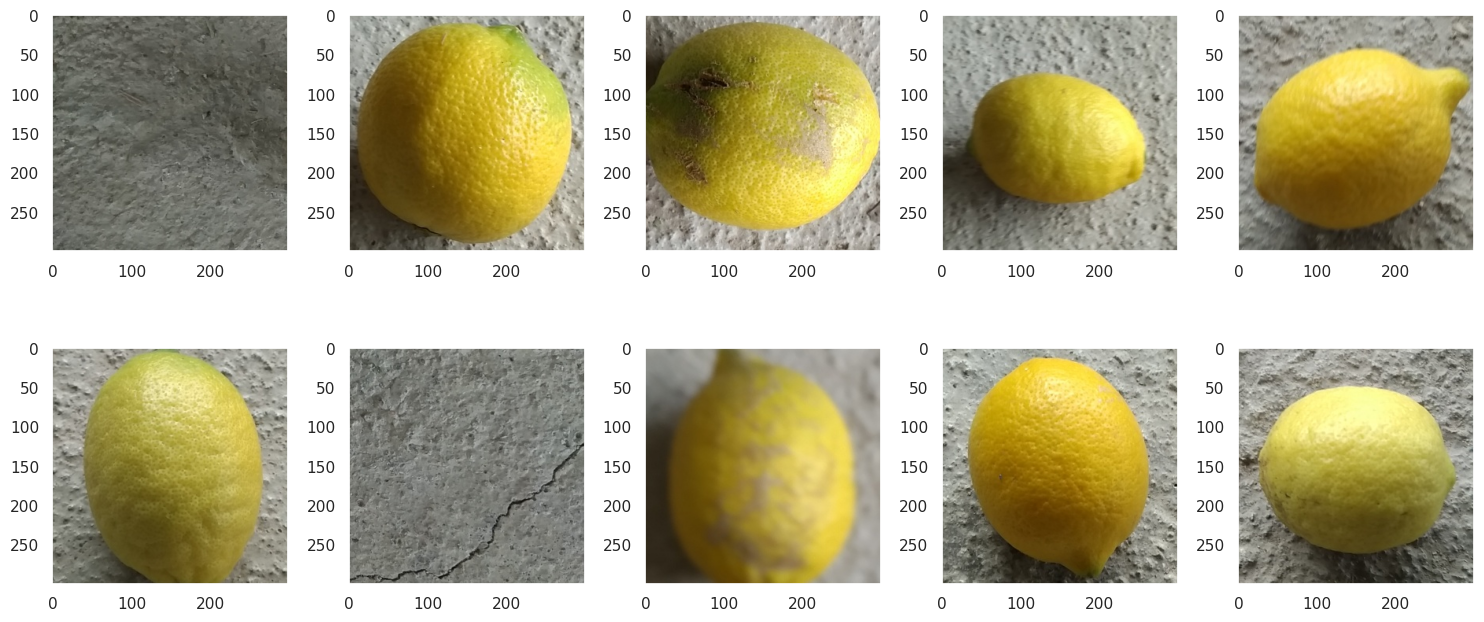

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for ax in axes.flat:
    i = np.random.randint(0, data.shape[0])
    ax.imshow(Image.open(data.loc[i, "Image"]))
    ax.grid(False)  

plt.tight_layout()
plt.show()

**Train-Test Split:**

In [15]:
dev, held_out =train_test_split(
    data, 
    train_size=0.9, 
    shuffle=True,
    random_state=42)

**Printing Shape Information:**

In [16]:
print(dev.shape)
print(held_out.shape)

(2275, 2)
(253, 2)


# Data Preprocessing and Image Data Generators

In [18]:
import keras

In [20]:
from keras.preprocessing import image

**Rescaling,Data Augmentation and rescaling**

In [23]:
# Rescaling and Data Augmentation
dev_generator = image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    validation_split=0.2
)

# In this case, the generator performs rescaling (normalization) on the image.
# Each pixel value is divided by 255 to obtain values in the range [0, 1].
held_generator = image.ImageDataGenerator(rescale=1./255)

**Flow from DataFrame:**

In [24]:
train_images = dev_generator.flow_from_dataframe(
    dataframe=dev,  # Make sure to provide the correct DataFrame
    x_col='Image',  # Update to the correct column name for images
    y_col='Quality',  # Update to the correct column name for labels
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1820 validated image filenames belonging to 3 classes.


In [25]:
val_images = dev_generator.flow_from_dataframe(
    dataframe=dev,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 455 validated image filenames belonging to 3 classes.


**Flow from DataFrame for Testing**

In [26]:
held_images = held_generator.flow_from_dataframe(
    dataframe=held_out,
    x_col='Image',
    y_col='Quality',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 253 validated image filenames belonging to 3 classes.


**class indices**

In [27]:
labels = train_images.class_indices
labels

{'bad_quality': 0, 'empty_background': 1, 'good_quality': 2}

# AlexNet Architecture for Image Classification

This code implements the AlexNet architecture using Keras. It defines a sequential model and adds convolutional, pooling, and dense layers to construct the network. The model consists of **8 convolutional layers** with **ReLU activation**, **max pooling**, and **zero padding**. It also includes 3 **fully connected layers** with dropout for regularization. The output layer has softmax activation for **multi-class classification**. The model is compiled with the **SGD optimizer** and categorical cross-entropy loss. Two callbacks, **early stopping and reduce learning rate on plateau**, are defined. The model is trained using the `fit()` function with provided training and validation datasets.





In [29]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, ZeroPadding2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [30]:
# Create AlexNet model
model = Sequential()

In [31]:

# Layer 1
model.add(Convolution2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
model.add(ZeroPadding2D(padding=(2, 2)))
model.add(Convolution2D(filters=256, kernel_size=(5, 5), strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(filters=384, kernel_size=(3, 3), strides=(1, 1)))
model.add(Activation('relu'))

# Layer 4
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(filters=384, kernel_size=(3, 3), strides=(1, 1)))
model.add(Activation('relu'))

# Layer 5
model.add(ZeroPadding2D(padding=(1, 1)))
model.add(Convolution2D(filters=256, kernel_size=(3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Flatten layer
model.add(Flatten())

# Layer 6
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 7
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Layer 8
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3))
model.add(Activation('softmax'))


In [32]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 96)        34944     
                                                                 
 activation (Activation)     (None, 35, 35, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 21, 21, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [33]:
# Define optimizer
optimizer = SGD(learning_rate=0.01, momentum=0.9)

In [34]:
# Compile model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc', 'mse'])

In [35]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]


In [37]:
# Train the model
history = model.fit(train_images, validation_data=val_images,epochs=30, callbacks=callbacks_list)

Epoch 1/30
57/57 [==============================] - 79s 1s/step - loss: 0.8523 - acc: 0.5148 - mse: 0.1870 - val_loss: 0.7210 - val_acc: 0.5780 - val_mse: 0.1607 - lr: 0.0100
Epoch 2/30
57/57 [==============================] - 79s 1s/step - loss: 0.7519 - acc: 0.6192 - mse: 0.1667 - val_loss: 0.6637 - val_acc: 0.5560 - val_mse: 0.1526 - lr: 0.0100
Epoch 3/30
57/57 [==============================] - 75s 1s/step - loss: 0.6141 - acc: 0.6725 - mse: 0.1365 - val_loss: 0.5492 - val_acc: 0.7626 - val_mse: 0.1190 - lr: 0.0100
Epoch 4/30
57/57 [==============================] - 80s 1s/step - loss: 0.5476 - acc: 0.7335 - mse: 0.1199 - val_loss: 0.4828 - val_acc: 0.7429 - val_mse: 0.1054 - lr: 0.0100
Epoch 5/30
57/57 [==============================] - 80s 1s/step - loss: 0.4583 - acc: 0.7978 - mse: 0.0971 - val_loss: 0.4130 - val_acc: 0.8242 - val_mse: 0.0819 - lr: 0.0100
Epoch 6/30
57/57 [==============================] - 80s 1s/step - loss: 0.4305 - acc: 0.8060 - mse: 0.0909 - val_loss: 0.3311

# Training and Validation Metrics Visualization

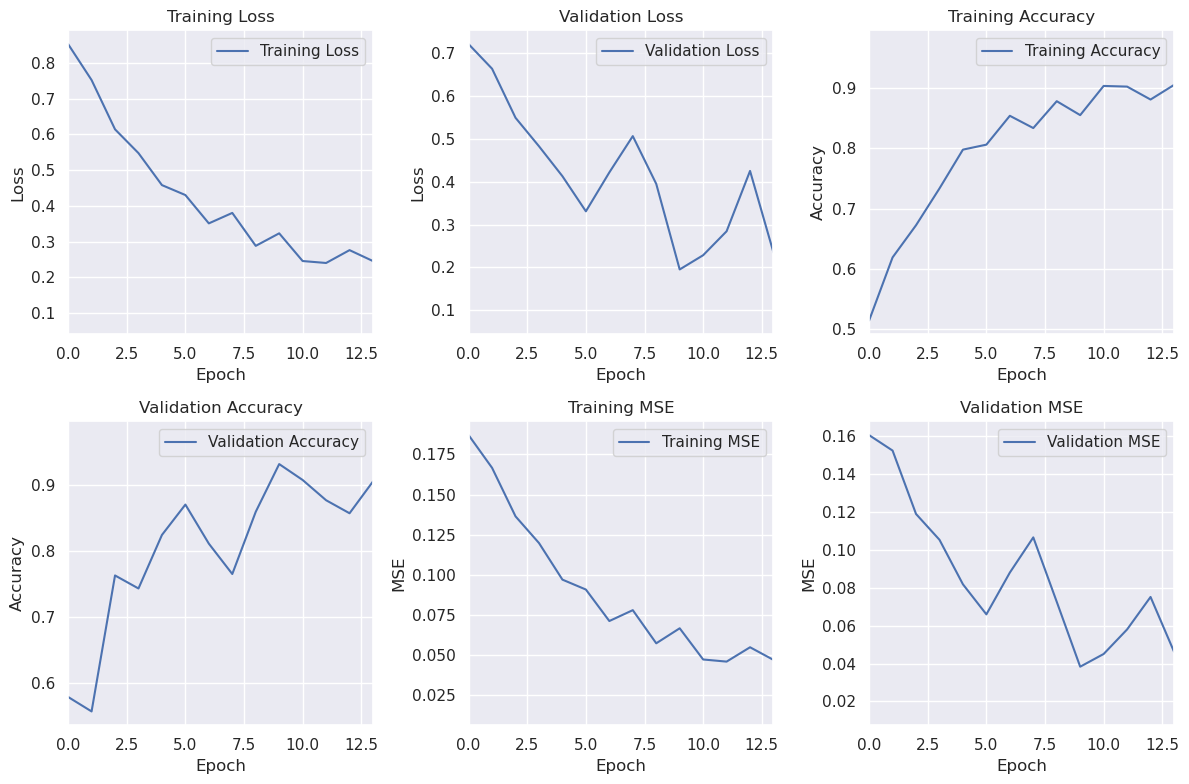

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot training loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)
axes[0, 0].set_xlim([0, 13])  # Set x-axis limits

# Plot validation loss
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].set_xlim([0, 13])  # Set x-axis limits

# Plot training accuracy
axes[0, 2].plot(history.history['acc'], label='Training Accuracy')
axes[0, 2].set_title('Training Accuracy')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].legend()
axes[0, 2].grid(True)
axes[0, 2].set_xlim([0, 13])  # Set x-axis limits

# Plot validation accuracy
axes[1, 0].plot(history.history['val_acc'], label='Validation Accuracy')
axes[1, 0].set_title('Validation Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)
axes[1, 0].set_xlim([0, 13])  # Set x-axis limits

# Plot training MSE (mean squared error)
axes[1, 1].plot(history.history['mse'], label='Training MSE')
axes[1, 1].set_title('Training MSE')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].set_xlim([0,13])  # Set x-axis limits

# Plot validation MSE
axes[1, 2].plot(history.history['val_mse'], label='Validation MSE')
axes[1, 2].set_title('Validation MSE')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MSE')
axes[1, 2].legend()
axes[1, 2].grid(True)
axes[1, 2].set_xlim([0,13])  # Set x-axis limits

plt.tight_layout()
plt.show()


**Model Prediction and Evaluation**

In [39]:
prediction=model.predict(held_images)

8/8 [==============================] - 3s 323ms/step


In [40]:
prediction=np.argmax(prediction, axis=1)
prediction.shape

(253,)

In [41]:
labels = train_images.class_indices
labels = {v: k for k, v in labels.items()}

In [42]:
y_prediction = [labels.get(k) for k in prediction]
y_test = held_out["Quality"].values

**Accuracy Evaluation**

In [43]:
from sklearn.metrics import accuracy_score, classification_report
print(classification_report(y_test, y_prediction))

                  precision    recall  f1-score   support

     bad_quality       0.95      0.93      0.94        90
empty_background       1.00      1.00      1.00        44
    good_quality       0.95      0.97      0.96       119

        accuracy                           0.96       253
       macro avg       0.97      0.97      0.97       253
    weighted avg       0.96      0.96      0.96       253



In [44]:
accuracy_score(y_prediction, y_test)

0.9604743083003953

**Confusion Matrix**

In [45]:
from sklearn.metrics import confusion_matrix

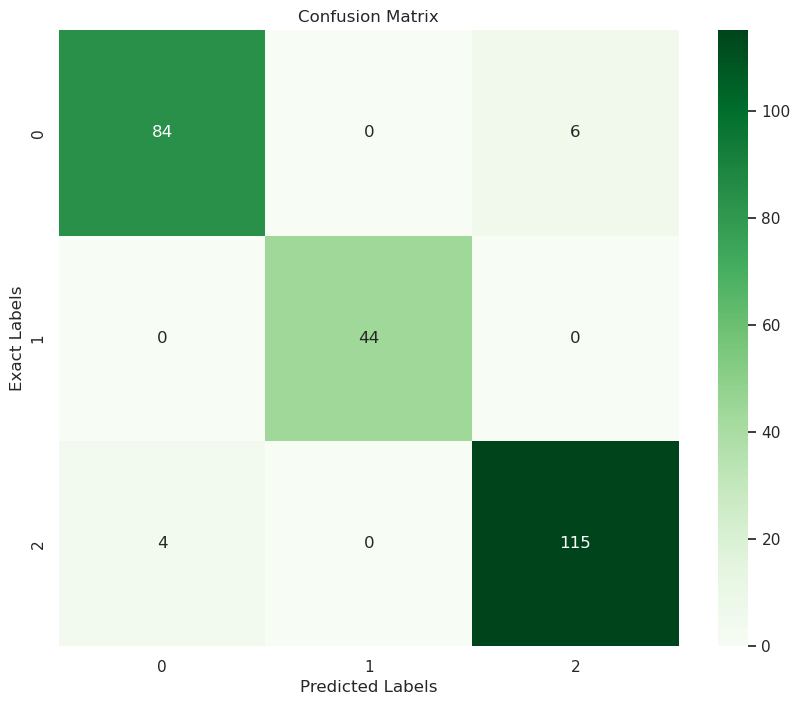

In [46]:
cm = confusion_matrix(y_test, y_prediction)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("Exact Labels")
plt.show()

# Visualizing Predicted Labels on Random Images

In [47]:
held_out.reset_index(drop=True, inplace=True)
held_out.head()

,Image,Quality
0,/kaggle/input/lemon-quality-dataset/lemon_data...,bad_quality
1,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality
2,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
3,/kaggle/input/lemon-quality-dataset/lemon_data...,empty_background
4,/kaggle/input/lemon-quality-dataset/lemon_data...,good_quality


In [48]:
random_index = np.random.randint(0, held_out.shape[0])
image_path = held_out.loc[random_index, "Image"]
predicted_label = y_prediction[random_index]

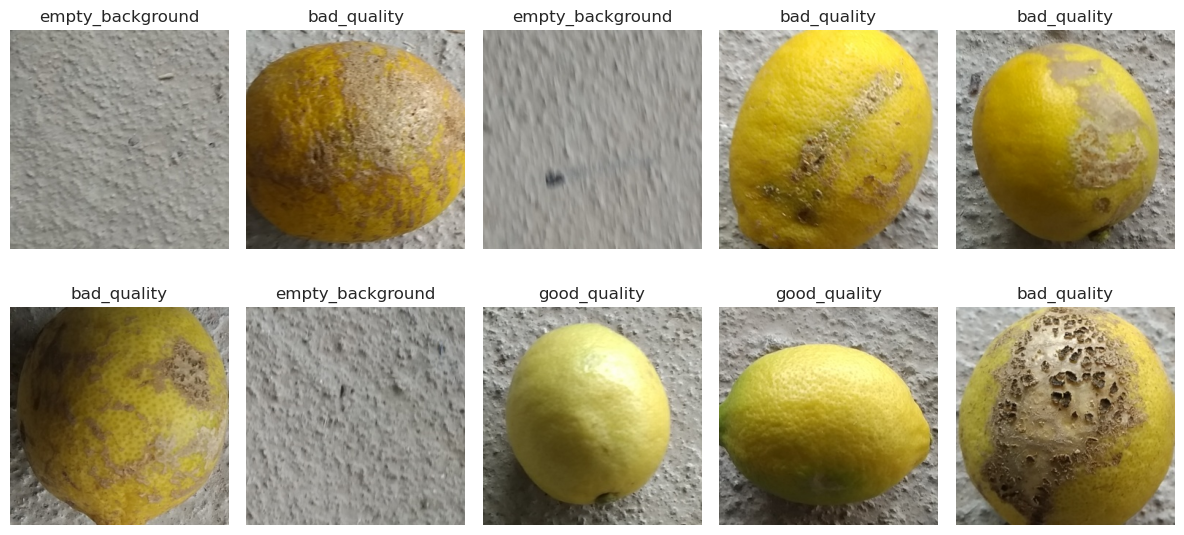

In [54]:
# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

# Iterate over the axes and randomly select 10 indices
for i, ax in enumerate(axes.flatten()):
    random_index = np.random.randint(0, held_out.shape[0])
    image_path = held_out.loc[random_index, "Image"]
    predicted_label = y_prediction[random_index]

    # Plot the image on the current subplot
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(predicted_label)

# Adjust spacing and display the plot
plt.tight_layout()
plt.show()

In [51]:
import tensorflow as tf

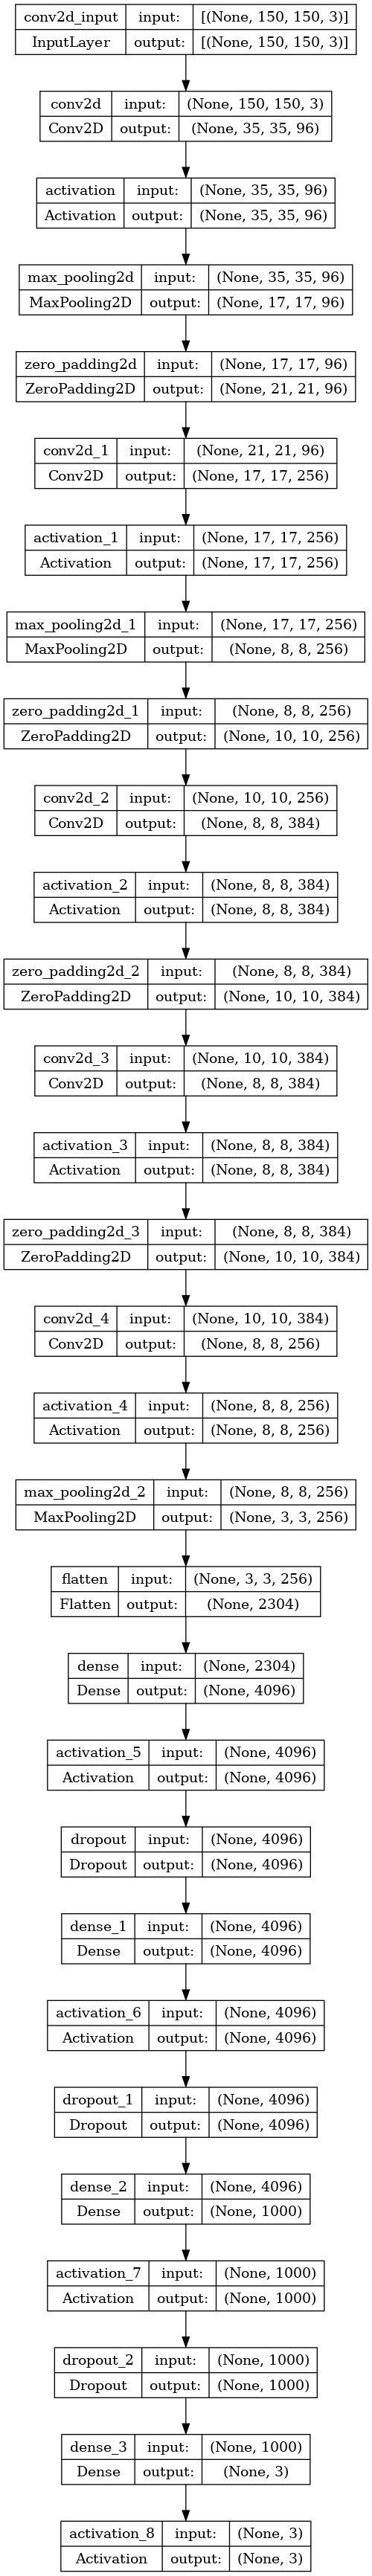

In [52]:
tf.keras.utils.plot_model(model, to_file='complex_model.png', show_shapes=True)